In [1]:
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
%pylab inline
import os
from __future__ import print_function
from __future__ import division
import os, sys
# hook up all scripts
sys.path.append(os.path.abspath('../scripts')) # if notebook in folder
sys.path.append(os.path.abspath('./scripts')) #if in root
import preprocessing_time_series as pts


os.chdir(pts.working_dir())

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_train = pd.read_csv('Feature_releases/release_v01/train_NAYARIT.csv')
print(data_train.shape)
data_train.head()

(809684, 24)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,No_remains,Venta_hoy_by_uni,Ordered,Log_Demanda,Median_Producto_ID,LogMean_Producto_ID,Median_Producto_ID_Ruta_SAK,LogMean_Producto_ID_Ruta_SAK,Median_Producto_ID_Cliente_ID_Agencia_ID,LogMean_Producto_ID_Cliente_ID_Agencia_ID
0,3,1340,1,1051,41849,73,1,21.32,0,0.0,...,0,21.32,1,0.693147,2.0,1.118843,2.0,1.122955,1.0,0.774240
1,3,1340,1,1051,41849,1109,6,90.06,0,0.0,...,0,15.01,1,1.945910,2.0,1.171162,3.0,1.416386,6.0,1.805732
2,3,1340,1,1051,41849,1125,13,124.80,0,0.0,...,0,9.60,1,2.639057,6.0,1.971653,6.0,2.024443,9.5,2.042122
3,3,1340,1,1051,41849,1150,1,13.96,0,0.0,...,0,13.96,1,0.693147,2.0,1.448213,2.5,1.471629,2.0,1.080011
4,3,1340,1,1051,41849,2233,4,79.76,0,0.0,...,0,19.94,1,1.609438,3.0,1.409244,3.0,1.517772,3.0,1.399732


In [3]:
town = pts.text_encoding(pts.town_preproc())
agencies = set(town.loc[town.State == u'NAYARIT'].index)
len(agencies)

Data endoded


10

In [4]:
data_test = pd.read_csv('test.csv', index_col=0)
data_test = data_test.loc[data_test.Agencia_ID.isin(agencies), :]
print(data_test.shape)
data_test.head()

(78819, 6)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
id,,,,,,
42,11,1378,1,2005,594640,43285
59,10,1359,11,3957,2068213,6469
129,10,1378,1,2101,905734,37577
183,11,1340,1,2065,325592,43285
203,11,1340,1,2052,7729188,43274


In [5]:
data = pd.concat([data_train, data_test], axis=0)
# del data_train
# del data_test

In [6]:
data = pts.lag_generation(data, n_lags=5)
data.index.name = 'id'
data = data.drop([u'Town', u'State', u'Venta_uni_hoy', u'Venta_hoy', u'Dev_uni_proxima',
       u'Dev_proxima', u'Demanda_uni_equil', u'Dev_proxima_by_uni', u'No_remains', 
        u'Venta_hoy_by_uni', u'Ordered',u'Median_Producto_ID',
       u'LogMean_Producto_ID', u'Median_Producto_ID_Ruta_SAK',
       u'LogMean_Producto_ID_Ruta_SAK',
       u'Median_Producto_ID_Cliente_ID_Agencia_ID',
       u'LogMean_Producto_ID_Cliente_ID_Agencia_ID'], axis=1).reset_index().set_index(u'Semana')
# data = data.swaplevel(i=0, j=-1, axis=0)
data.head()

1 lag done
2 lag done
3 lag done
4 lag done
5 lag done


,id,Agencia_ID,Canal_ID,Cliente_ID,Log_Demanda,Producto_ID,Ruta_SAK,Venta_uni_hoy_1,Venta_hoy_1,Dev_uni_proxima_1,...,No_remains_5,Venta_hoy_by_uni_5,Ordered_5,Log_Demanda_5,Median_Producto_ID_5,LogMean_Producto_ID_5,Median_Producto_ID_Ruta_SAK_5,LogMean_Producto_ID_Ruta_SAK_5,Median_Producto_ID_Cliente_ID_Agencia_ID_5,LogMean_Producto_ID_Cliente_ID_Agencia_ID_5
Semana,,,,,,,,,,,,,,,,,,,,,
3,0,1340,1,41849,0.693147,73,1051,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1340,1,41849,1.945910,1109,1051,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1340,1,41849,2.639057,1125,1051,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1340,1,41849,0.693147,1150,1051,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1340,1,41849,1.609438,2233,1051,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
X_train = data.loc[3:7,:].drop('Log_Demanda', axis=1).set_index('id', append=True)
y_train = data.loc[3:7,:].set_index('id', append=True)['Log_Demanda']
X_test = data.loc[8:9,:].drop('Log_Demanda', axis=1).set_index('id', append=True)
y_test = data.loc[8:9,:].set_index('id', append=True)['Log_Demanda']
# X_eval = data.loc[10:11,:].drop('Log_Demanda', axis=1).set_index('id', append=True)

# xgboost 

Обнаружил, что для learning_rate=0.3 оптимальное количество деревьев 100.

Сейчас подбираю параметры max_depth и min_child_weight. (15 и 12)

Потом надо подобрать [gamma], [subsample, colsample_bytree], [lambda(L2), alpha(L1)]. 

In [8]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error

def plot_feature_importances(xgb_model):
    plt.figure(figsize=(20,10))
    feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [9]:
# param = clf.best_params_
param = {
 'learning_rate': 0.3,
 'gamma': 0,
 'max_depth': 15,
 'min_child_weight': 12,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgb_model = xgb.XGBRegressor()
xgb_model.set_params(**param)
#scores = cross_val_score(xgb_model, X_train, y_train, scoring = 'mean_squared_error',
#                             cv = cv5fold, n_jobs=-1)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=15,
       min_child_weight=12, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

Train: 0.337154732763
Test: 0.425882513054


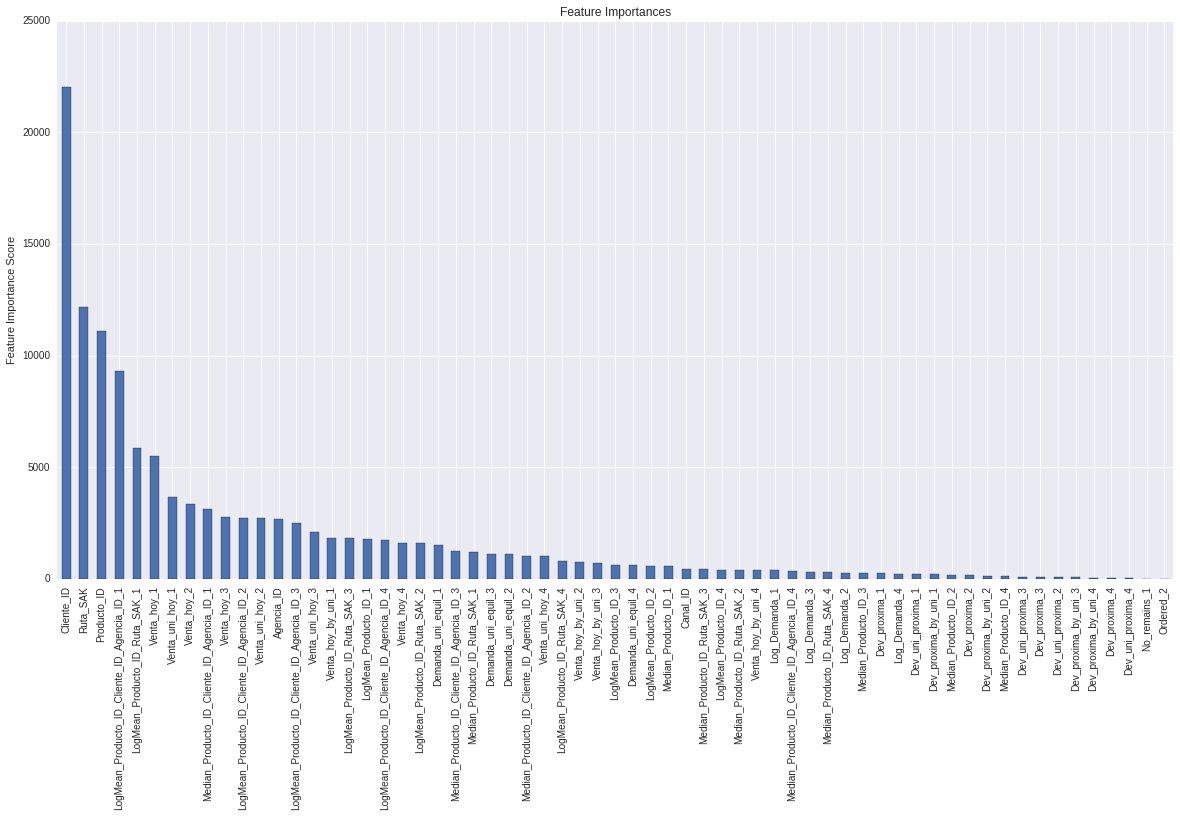

In [10]:
plot_feature_importances(xgb_model)

print('Train:', np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test))))

# Next week prediction

In [11]:
X_train2 = X_train[[col for col in X_train.columns if '_1' != col[-2:]]]
X_test2 = X_test[[col for col in X_test.columns if '_1' != col[-2:]]]
# X_eval2 = X_eval[[col for col in X_eval.columns if '_1' != col[-2:]]]
X_train2.shape, X_train.shape

((578138, 69), (578138, 85))

In [12]:
param = {
 'learning_rate': 0.3,
 'gamma': 0,
 'max_depth': 15,
 'min_child_weight': 12,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgb_model2 = xgb.XGBRegressor()
xgb_model2.set_params(**param)
#scores = cross_val_score(xgb_model2, X_train, y_train, scoring = 'mean_squared_error',
#                             cv = cv5fold, n_jobs=-1)

xgb_model2.fit(X_train2, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=15,
       min_child_weight=12, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

Train: 0.379552371212
Test: 0.469323956972


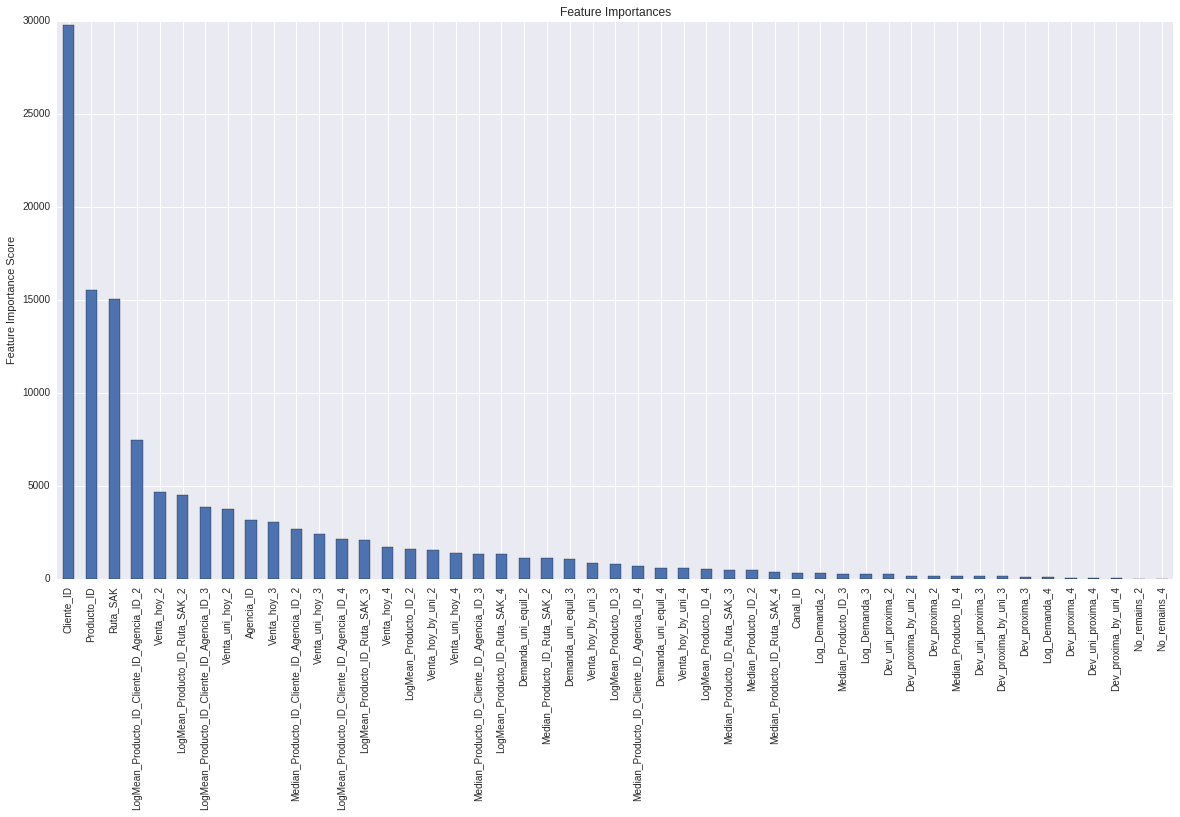

In [13]:
plot_feature_importances(xgb_model2)

print('Train:', np.sqrt(mean_squared_error(y_train, xgb_model2.predict(X_train2))))
print('Test:', np.sqrt(mean_squared_error(y_test, xgb_model2.predict(X_test2))))

# Cross-validation

In [ ]:
param = {
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 15,
 'min_child_weight': 12,
 'n_estimators': 100,
 'subsample': 0.8,
 'colsample_bytree': 0.8
}

xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(param, xgtrain, num_boost_round=200, nfold=5,
                    metrics='rmse', early_stopping_rounds=10)
cvresult

In [ ]:
grid_param = {
 'max_depth': [15, 17, 20, 23, 25],
 'min_child_weight': [5, 8, 10, 12],
}

xgb_model = xgb.XGBRegressor(n_estimators=78,
                             learning_rate = 0.3,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8)

clf = GridSearchCV(xgb_model, grid_param, cv=5,
                   scoring='mean_squared_error',verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

print(clf.best_score_)
print(clf.best_params_)
clf.grid_scores_

In [ ]:
plot_feature_importances(clf.best_estimator_)